## Knock Out Rules optimisation through NGSA II - Retraining Models

In [9]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  
import kooptimize.NGSAII as ngsa2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
train = pd.read_csv('data/train_fin_cols.csv')
#test = pd.read_csv('data/test_fin_cols.csv')

#Train on a random sub sample, as it takes time.
train = train.sample(50000)

y = train['loan_default']

#test_unique_id = test['uniqueid']
#test_unique_id = test_unique_id.reset_index()

train = train.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(train.shape))
print("Loaded train target with shape {}".format(y.shape))
#print("Loaded test target with shape {}".format(test.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

train = train.drop(categorical_columns_to_drop,axis=1)
#test = test.drop(categorical_columns_to_drop,axis=1)

Loaded train data with shape (50000, 58)
Loaded train target with shape (50000,)


When all KO rules are applied :

In [15]:
individual = [1,1,1,1,1,1,1,1,1,1]
selected_rules = ngsa2.get_rules_for_individual(individual)
X_ko,y_ko = ngsa2.apply_rules_to_df(train,y,selected_rules)
print("Application with all KO rules : {}".format(X_ko.shape[0]))

Application with all KO rules : 18803


In [16]:
import time
start_time = time.time()
feature_list =[1]*10
print("AUC with All features  : {} ".format(ngsa2.get_cv_score(X_ko,y_ko,feature_list,shuffle=False)))
chromosome_length = len(feature_list)
print("No.of KO Rules : {}".format(chromosome_length))
print("Time Taken : {} s".format(time.time()-start_time))

AUC with All features  : 66.2789888630415 
No.of KO Rules : 10
Time Taken : 48.81213092803955 s


Generation 0 out of 10 


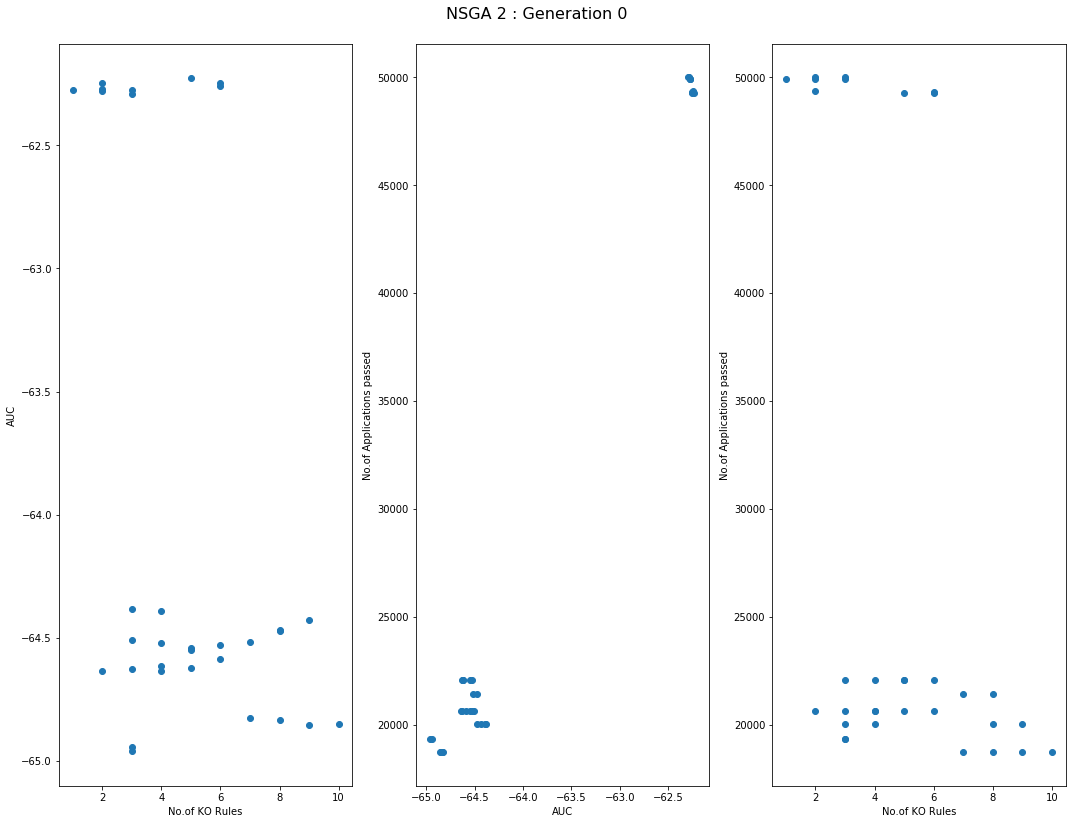

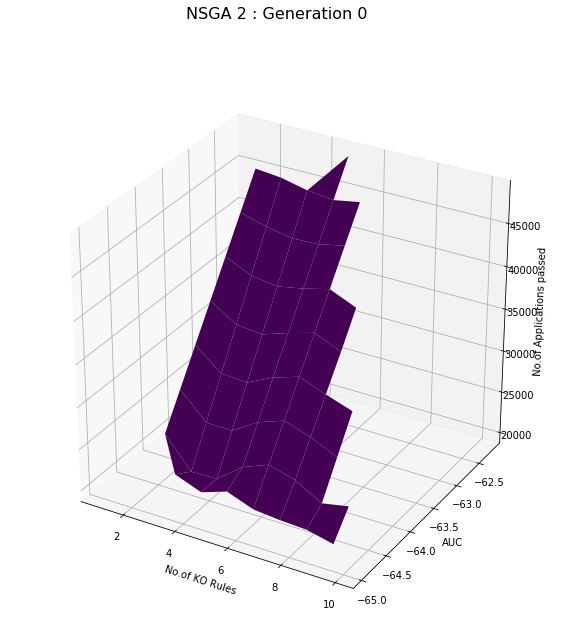

1023.7989838123322 secs for Generation 0 


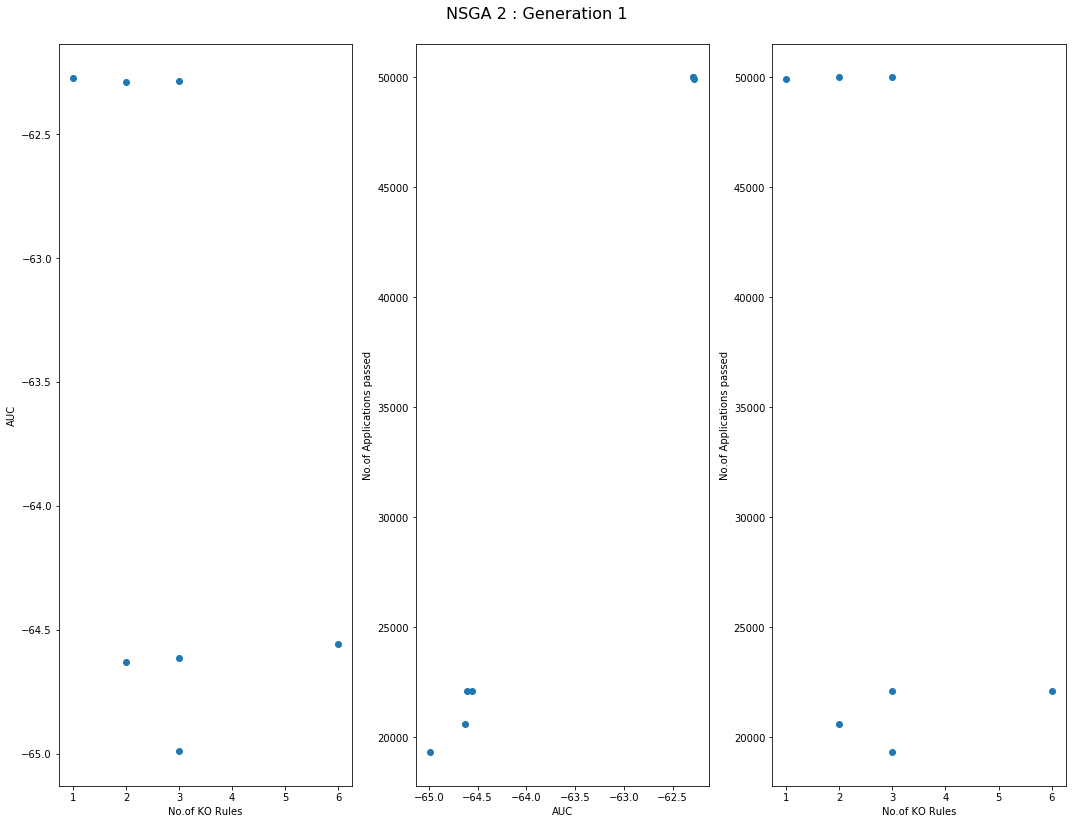

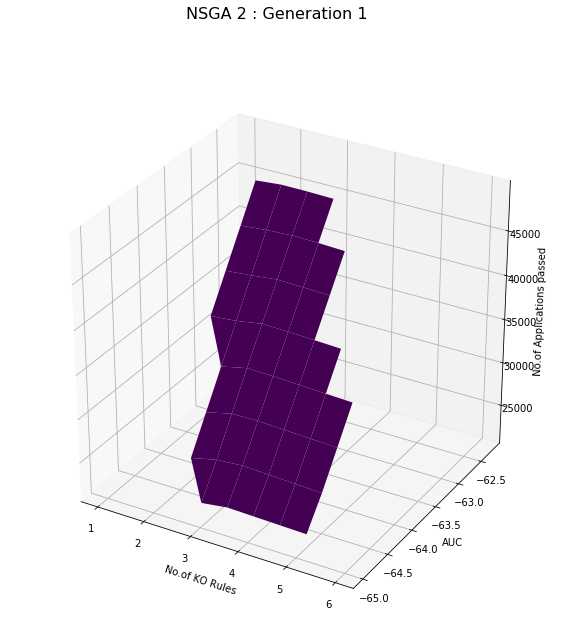

265.6120891571045 secs for Generation 1 


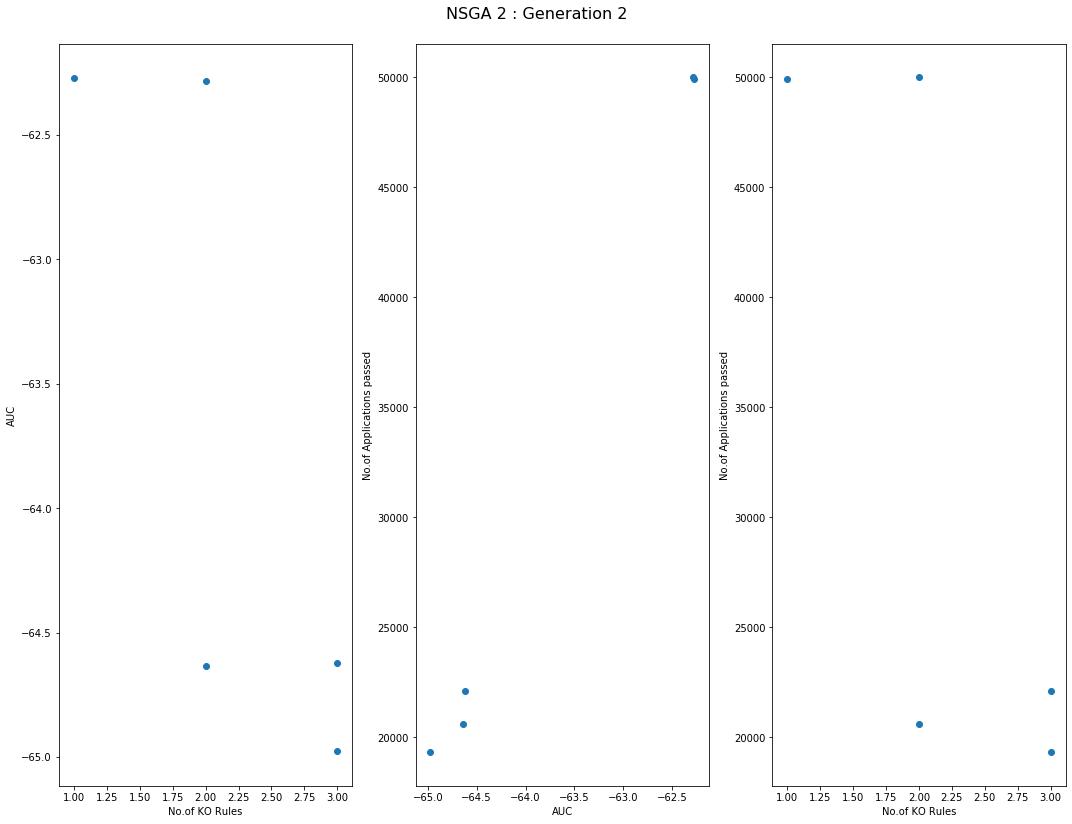

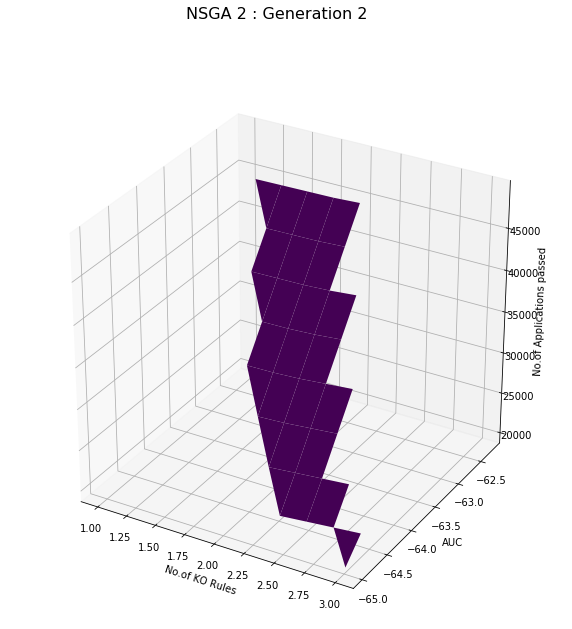

181.1067352294922 secs for Generation 2 


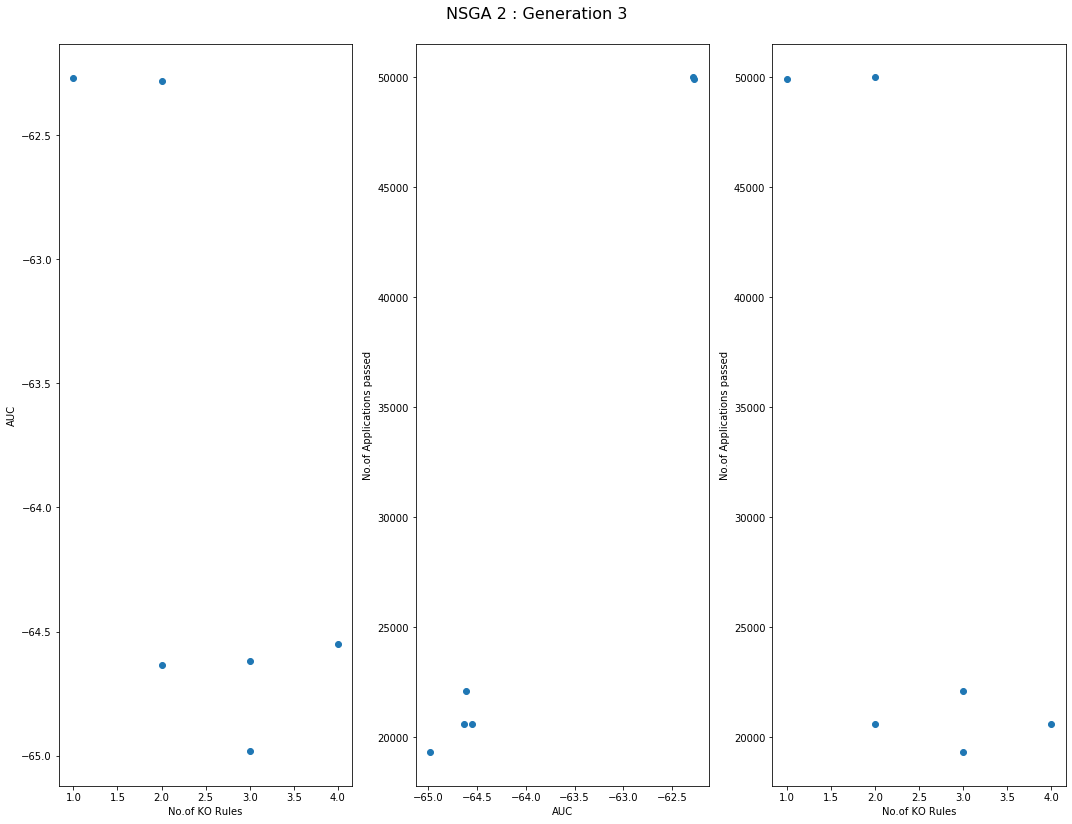

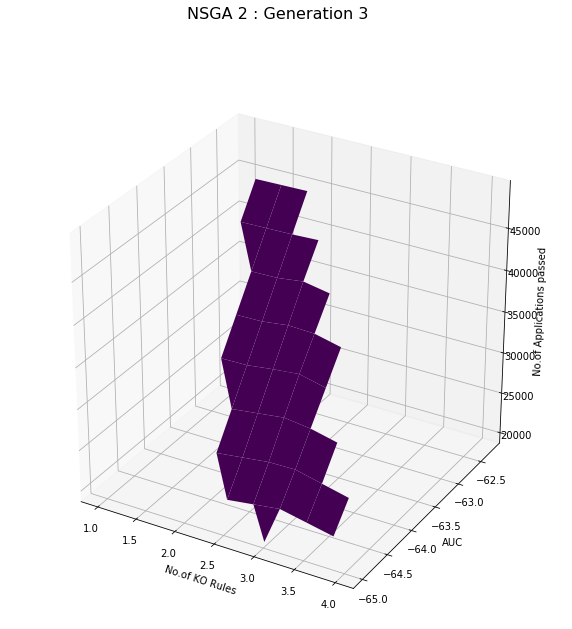

207.99077820777893 secs for Generation 3 


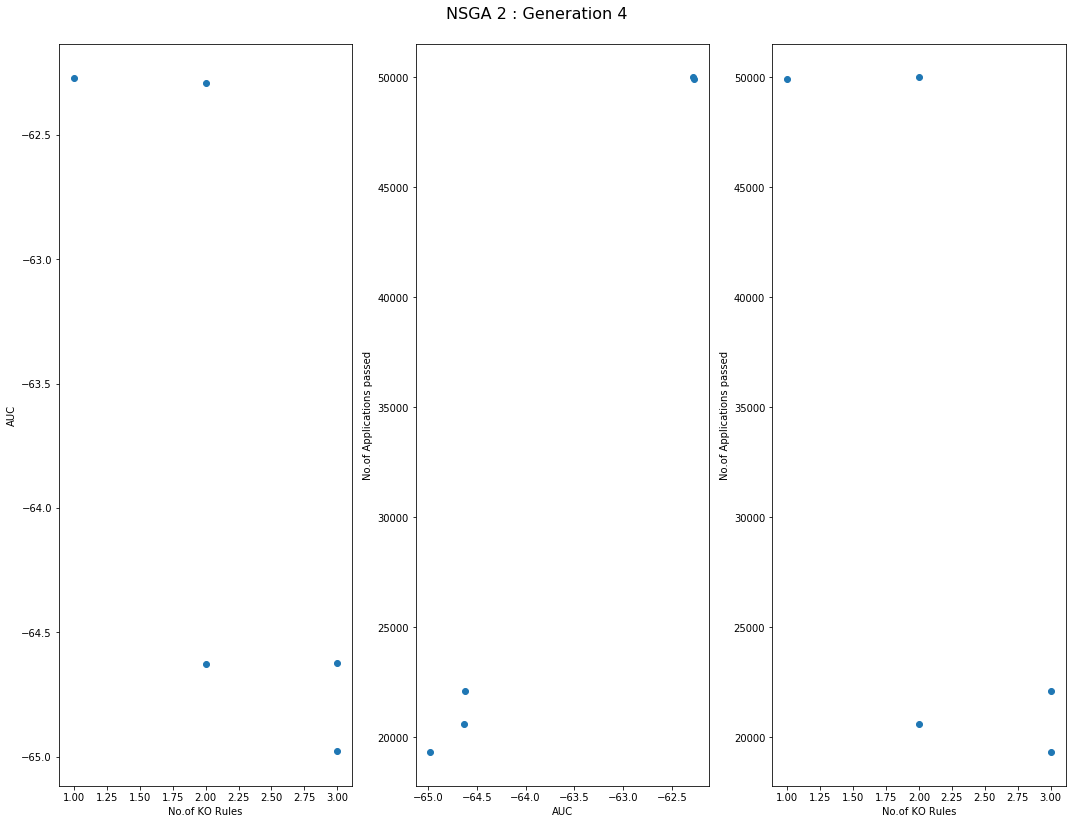

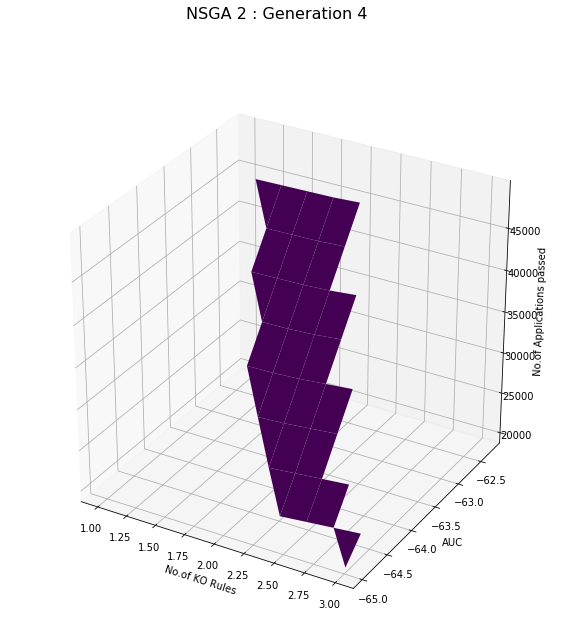

183.24211502075195 secs for Generation 4 


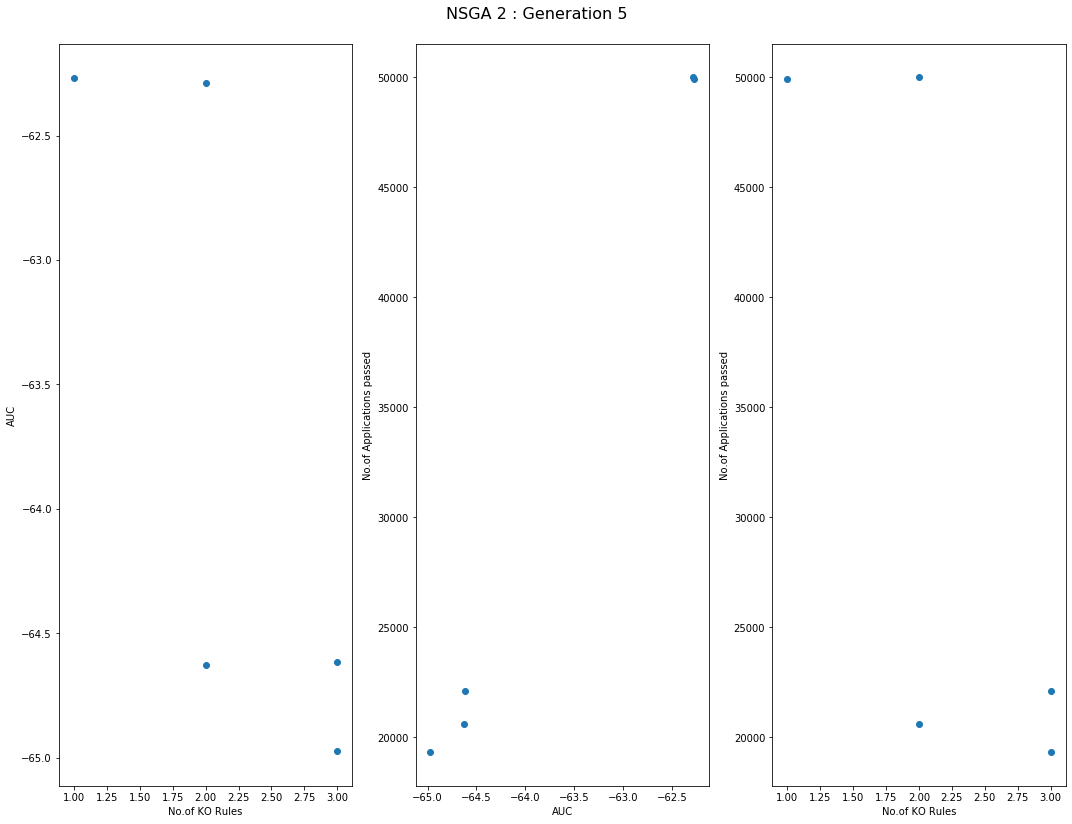

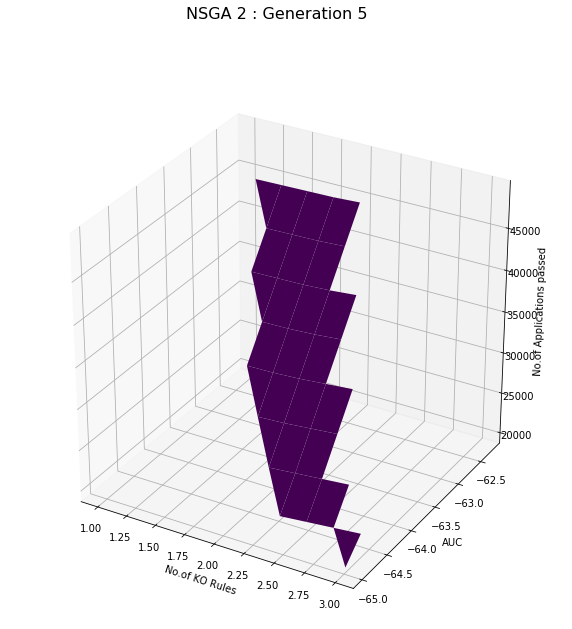

185.11862587928772 secs for Generation 5 


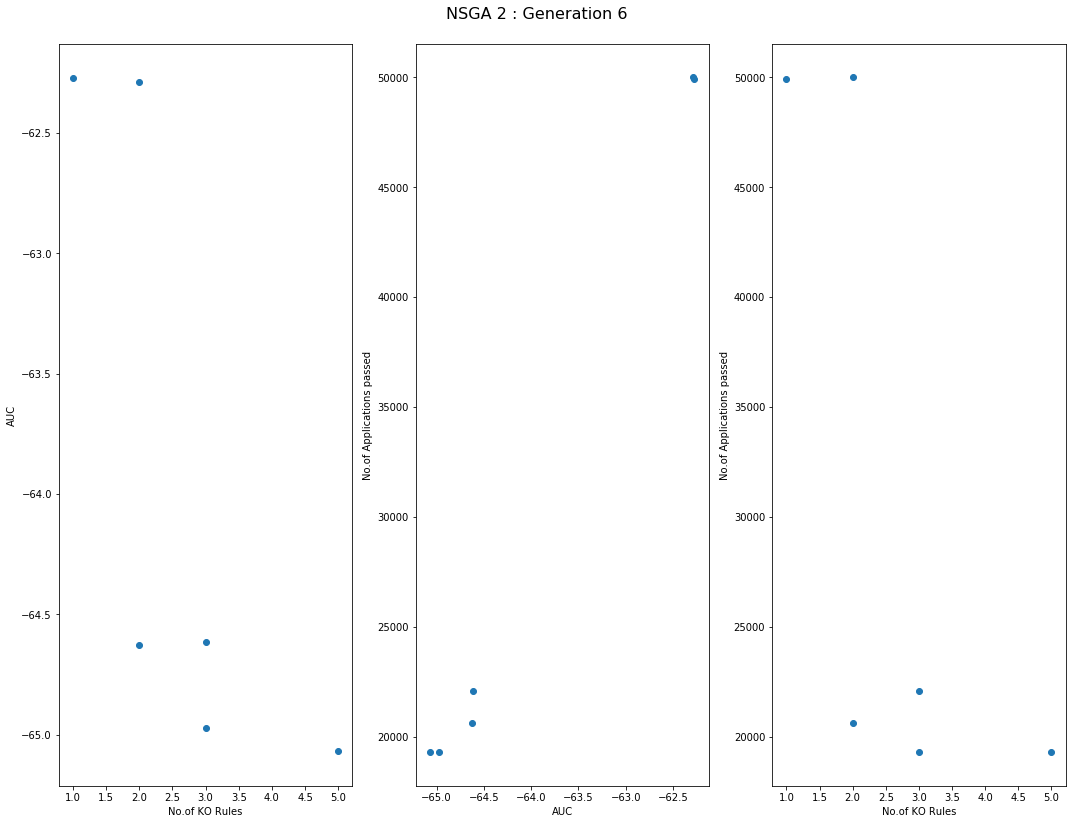

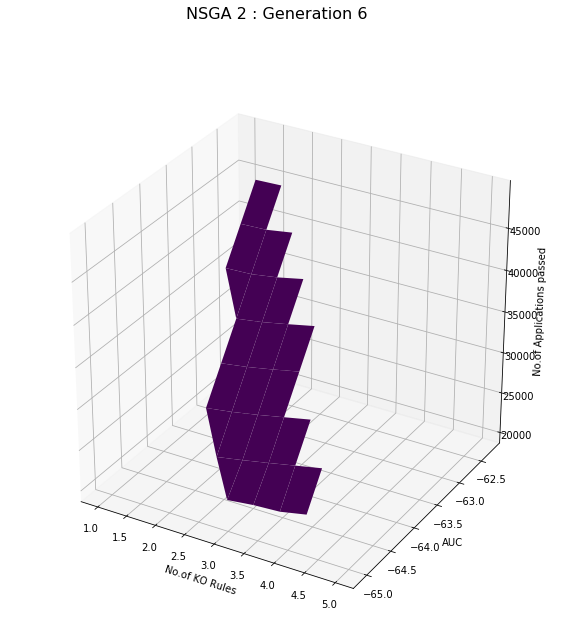

201.36947798728943 secs for Generation 6 


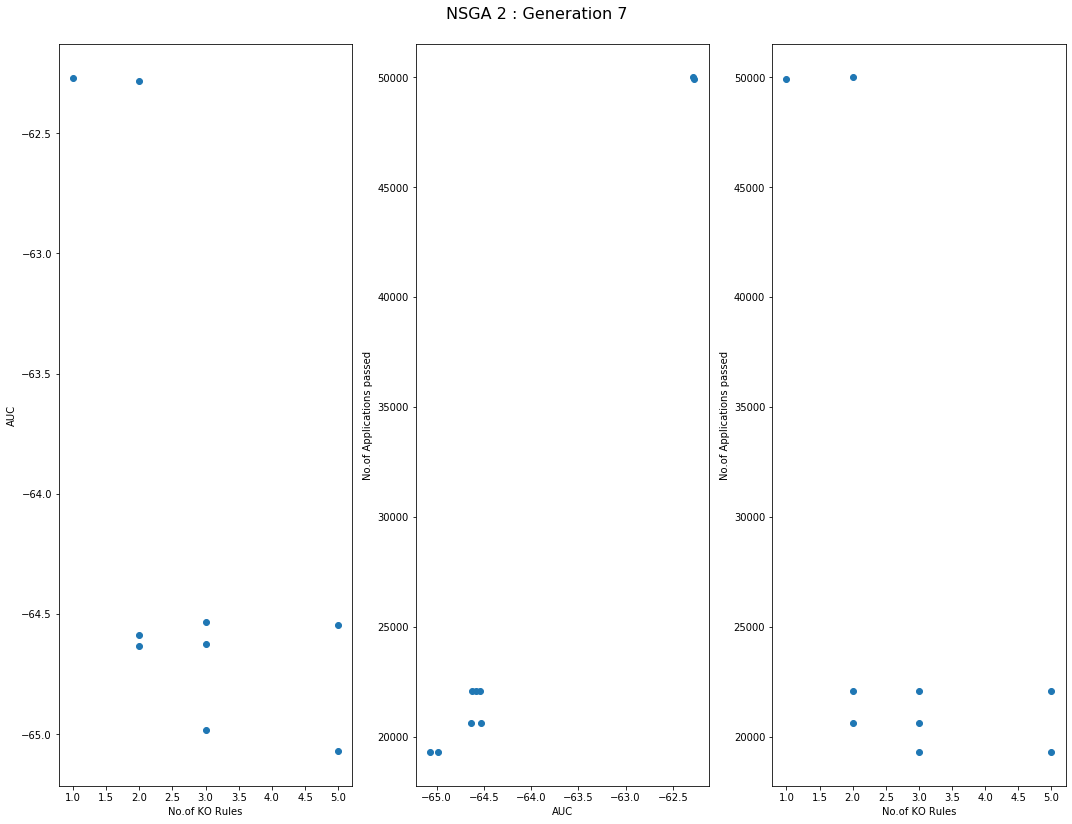

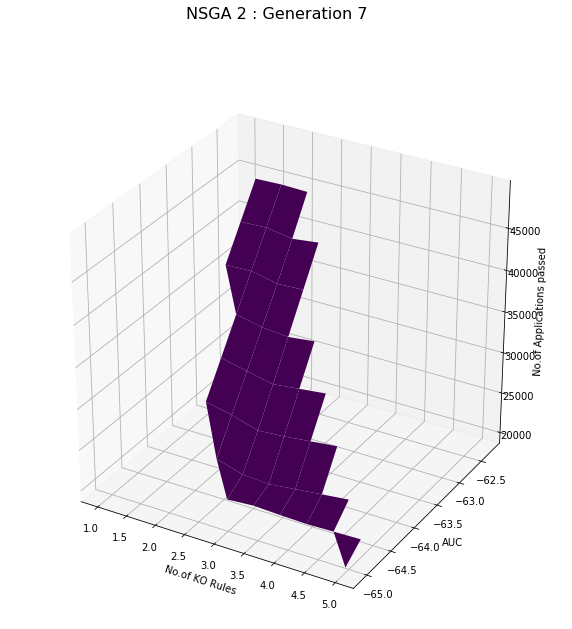

275.90017008781433 secs for Generation 7 


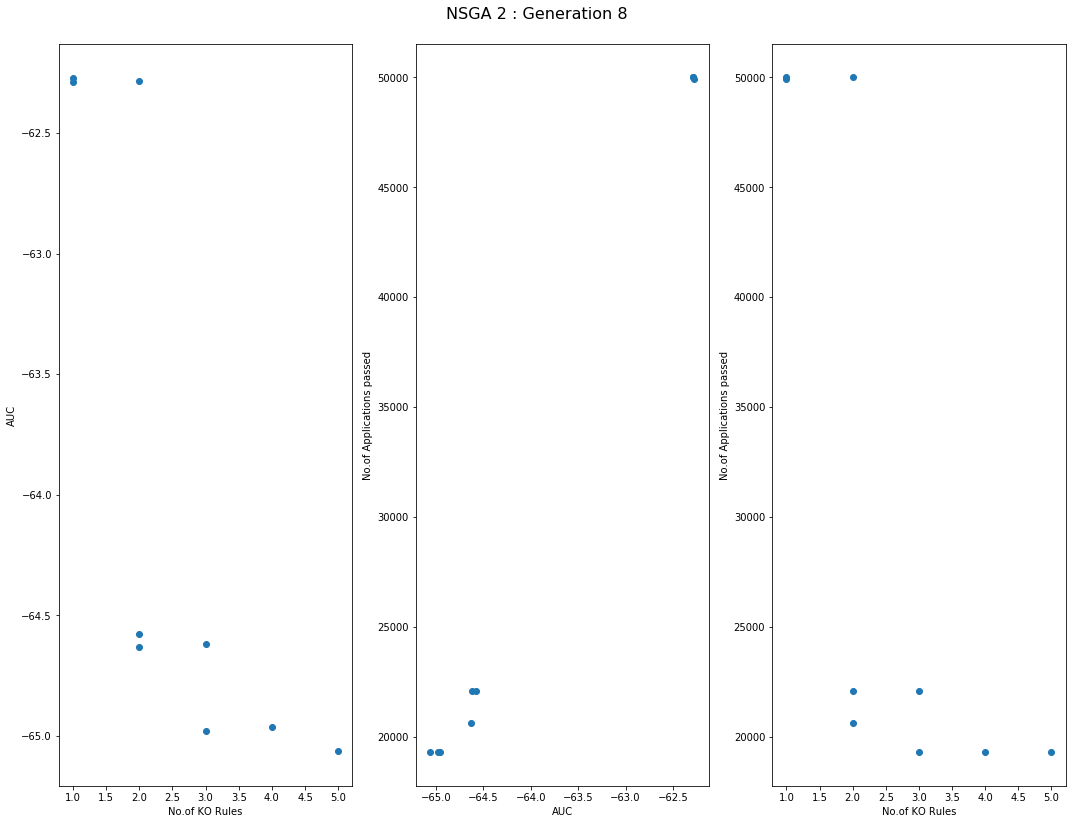

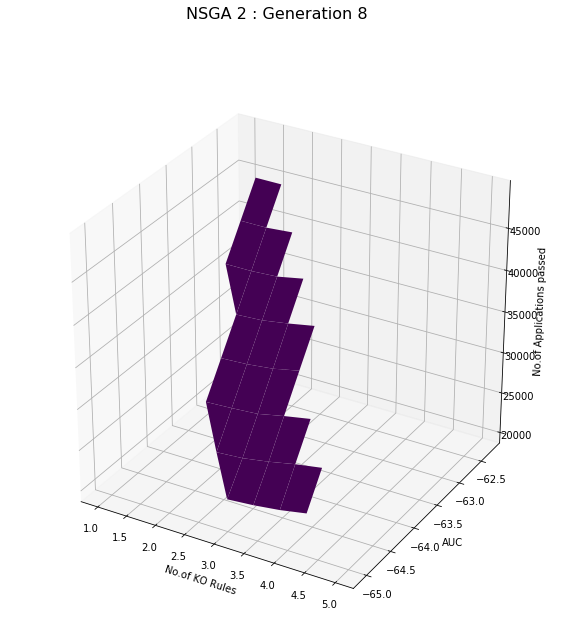

302.73734974861145 secs for Generation 8 


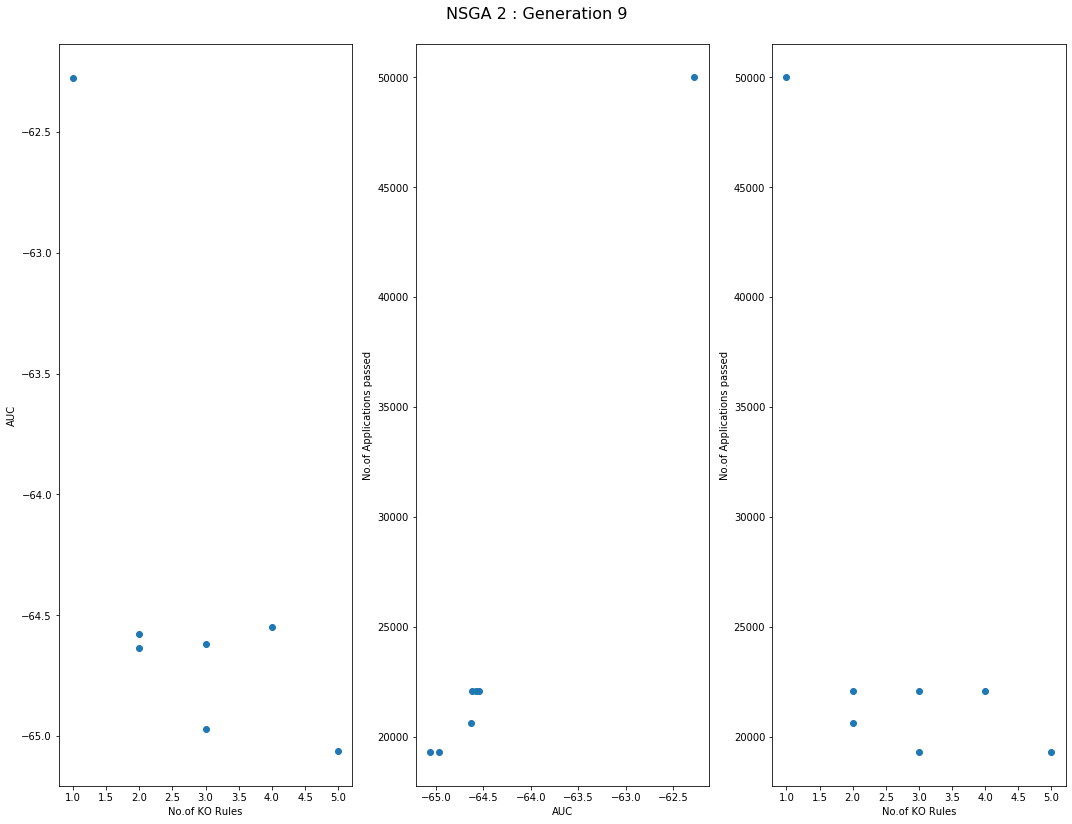

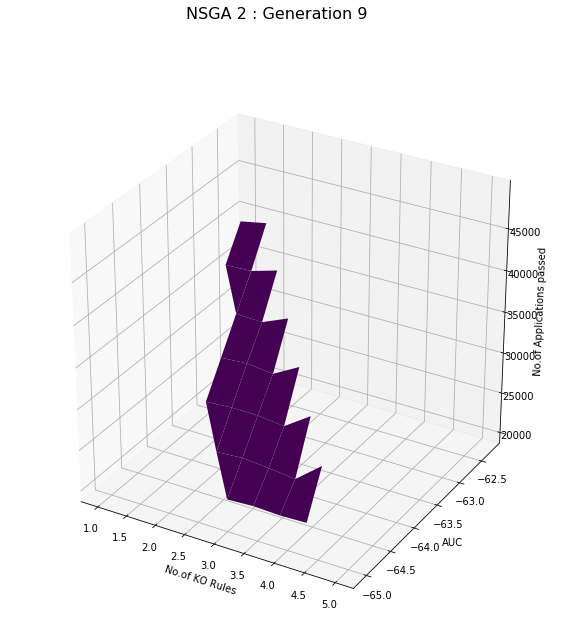

194.9500858783722 secs for Generation 9 


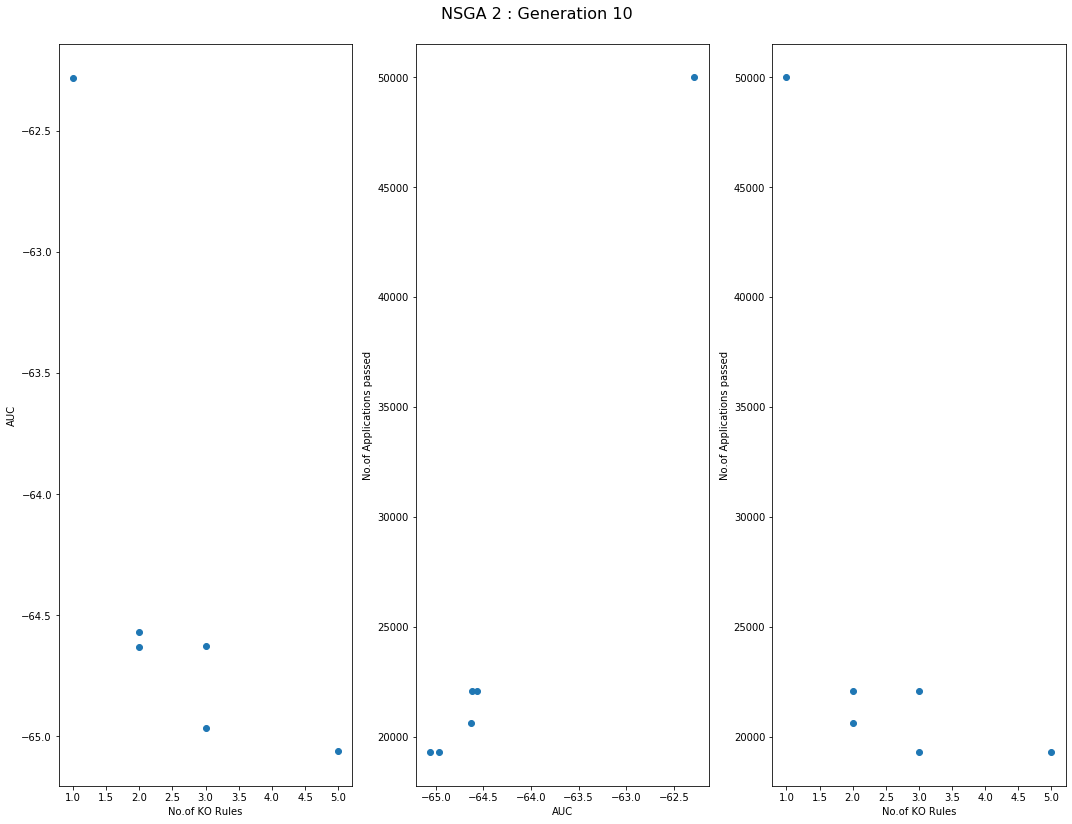

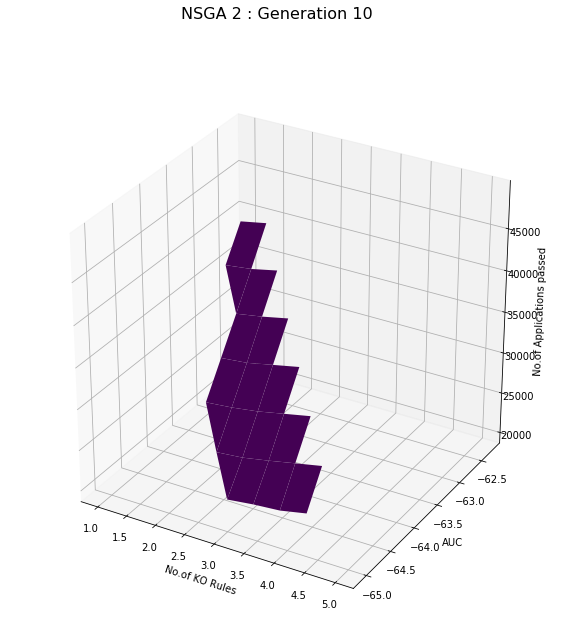

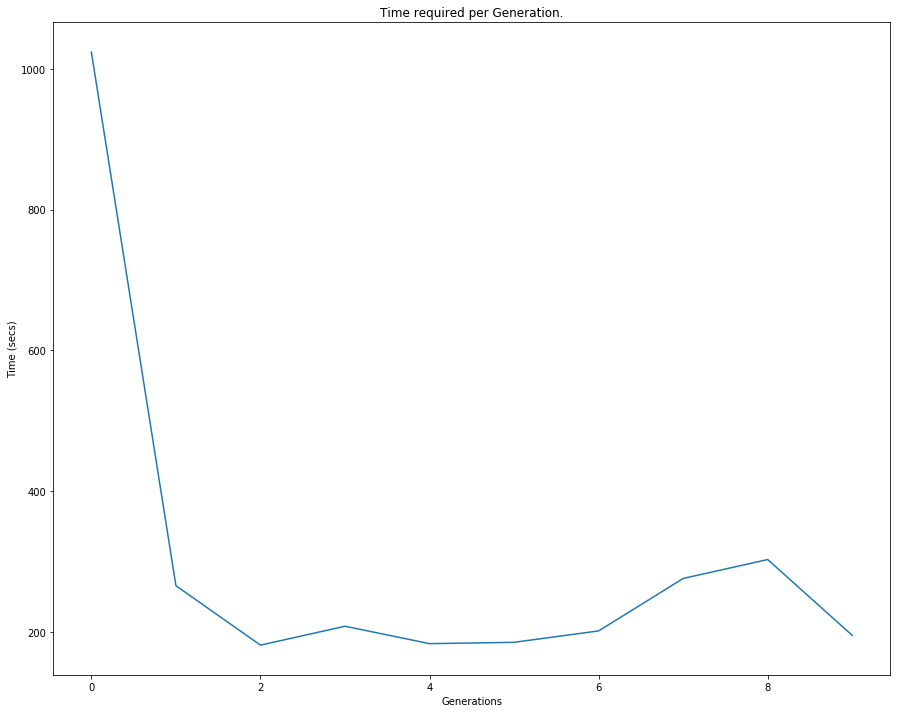

In [8]:
# Set general parameters
starting_population_size = 20
maximum_generation = 10
minimum_population_size = 5
maximum_population_size = 10
constraints=["No.of KO Rules","AUC","No.of Applications passed"]
# Create starting population
population = ngsa2.create_population(starting_population_size,chromosome_length)
population = np.unique(population, axis=0)
# Now we'll go through the generations of genetic algorithm

generation_list = []
time_required = []

for generation in range(maximum_generation):
    start_time = time.time()
    
    if generation %10 == 0:
        print ('Generation {} out of {} '.format(generation,maximum_generation))
    
    # Breed
    population = ngsa2.breed_population(population)
    
    # Score population
    population,scores = ngsa2.score_population(train,y,population)
    
    
    # Build pareto front
    population = ngsa2.build_pareto_population(
            population, scores, minimum_population_size, maximum_population_size)
    
    ngsa2.plot_2d_paretofront(scores,generation,constraints)
    ngsa2.plot_3d_paretofront(scores,generation,constraints)
    
    time_taken = time.time()-start_time
    print("{} secs for Generation {} ".format(time_taken,generation))
    
    generation_list.append(generation)
    time_required.append(time_taken)
    

# Get final pareto front
population,scores = ngsa2.score_population(train,y,population)
population_ids = np.arange(population.shape[0]).astype(int)
pareto_front = ngsa2.identify_pareto(scores, population_ids)
population = population[pareto_front, :]
scores = scores[pareto_front]

#Selected Population

ngsa2.plot_2d_paretofront(scores,generation+1,constraints)
ngsa2.plot_3d_paretofront(scores,generation+1,constraints)

ngsa2.plot_gen_time(generation_list,time_required)

### Final Results

In [9]:
ngsa2.show_population_score_df(population,scores)

,#Rules,AUC Diff,No.ofApplications,Rules
5,1.0,62.283128,49998.0,{5.0: 'sec_no_of_accts <= 35'}
0,2.0,64.570273,22102.0,"{8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10'}"
1,3.0,64.625137,22091.0,"{8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10', 10.0: 'amt_rejected <= 0.7'}"
3,2.0,64.631058,20628.0,"{6.0: 'avg_acct_age_m >= 6', 7.0: 'new_accts_in_last_six_months <= 10'}"
2,3.0,64.964017,19333.0,"{6.0: 'avg_acct_age_m >= 6', 8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10'}"
4,5.0,65.060494,19308.0,"{6.0: 'avg_acct_age_m >= 6', 7.0: 'new_accts_in_last_six_months <= 10', 8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10', 10.0: 'amt_rejected <= 0.7'}"
